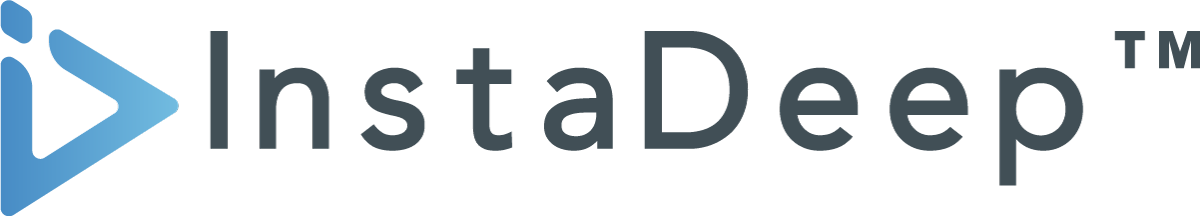

# What is this all about?

This notebook provides a code snippet to implement a protein classifier. Specifically, for each protein, the task is to assign the corresponding
Pfam family (i.e. protein family). You can find more information regarding the Pfam family [here](https://en.wikipedia.org/wiki/Pfam). 

The implemented model is inspired by [ProtCNN](https://www.biorxiv.org/content/10.1101/626507v3.full). 

## Where does the data come from?

The PFAM dataset is available [here](https://www.kaggle.com/googleai/pfam-seed-random-split).

## What we are expecting?

While this notebook provides a baseline model and some util functions to train the latter, its architecture is not suited for reproducibility, collaboration and portability. Therefore, your task is to refactor and augment the following basecode. In practice, we expect you to create a git repository and apply your suggestions, it should include but not limited:


- Build a local environment using docker
- Clean & refactor the code into python scripts (specifically, the user should be able to tweak training & model hyperparameters from the CLI)
- Add a command line to predict and/or evaluate a trained model
- Ensure code quality & consistency
- Document the repository
- Add tests
- ...

_The above list is not exhaustive and we are more than open to other suggestions and inititatives._

- _Bonus:_ Find a stronger model: e.g. optimize over hyperparameters, refine or change the architecture, etc.

---

- If you use _GitHub/GitLab_ to host your git repository, please make it **private**. To share your work with us, please launch from your repository `git bundle create <YOUR_NAME>.bundle --all` and send the resulting `<YOUR_NAME>.bundle` file to us.

- The notebook has been tested with `python==3.7.4` and the following dependencies:
```
matplotlib==3.4.1
numpy==1.18.5
pandas==1.2.3
pytorch-lightning==1.5.3
seaborn==0.11.1
tensorboard==2.2.2
torch==1.8.1
torchmetrics==0.6.0
```

- We use [PyTorch Lightning](https://www.pytorchlightning.ai/) for this pipeline's deep learning framework, but you are allowed to switch to any other ML/DL framework that you might prefer.
- *Warning:* The default number of GPUs is set to 0 but training without a GPU will be slow. In case you need more compute power than locally available on your computer, the following resources provide interesting amounts of computing power for free:
    - Google Colab: access to one GPU or one TPU, time limit of 12 hours (kernels are shut down after 12 hours)
    - Kaggle notebooks: access to one GPU (NVIDIA P100), time limit of 6 hours

# The Code

In [4]:
import os

from collections import Counter

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F

import pytorch_lightning as pl
import torchmetrics

In [5]:
torch.cuda.is_available()

False

In [6]:
data_dir = './random_split'

## Step 1: Define data loading and pre-processing

In [7]:
def reader(partition, data_path):
    data = []
    for file_name in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, file_name)) as file:
            data.append(pd.read_csv(file, index_col=None, usecols=["sequence", "family_accession"]))

    all_data = pd.concat(data)        
    return all_data["sequence"], all_data["family_accession"]

In [59]:
train_data, train_targets = reader("train", data_dir)
dev_data, dev_targets = reader("dev", data_dir)
test_data, test_targets = reader("dev", data_dir)

In [9]:
train_data.head()

0    ILEVGAGTGRYSLYYAEKGYNVNAIEYVEHNVEILKSKITNEMNIC...
1    FQLPQSIRFGLIAYTNTTTHKQTVNVYIDDLLVDTFTGKGTDTKAY...
2    VLNTQFGNGNLGGDFRNSVSFPLSWSKVKGAKSYAVTLIDYESTNT...
3    KKILLALSAKRIKIRDFINSKFLFPLTEVKEDGSIMLRDYFSVEED...
4    RIGLIGYTNAGKSSIMNALVGLDKEQYEQNELFATLDATTKAVKLV...
Name: sequence, dtype: object

In [10]:
def build_labels(targets):
    unique_targets = targets.unique()
    fam2label = {target: i for i, target in enumerate(unique_targets, start=1)}
    fam2label['<unk>'] = 0
    
    print(f"There are {len(fam2label)} labels.")
        
    return fam2label

In [60]:
fam2label = build_labels(dev_targets)

There are 13072 labels.


---
#### Data exploration and analysis: a few plots to understand the data at hand

⚠️ One can see that the provided dataset is **heavily imbalanced**: some families have up to roughly 3k samples while others only have around ten samples.

One can observe that the sequences' lengths are quite different over the dataset.

In [15]:
def get_amino_acid_frequencies(data):
    aa_counter = Counter()
    
    for sequence in data:
        aa_counter.update(sequence)
        
    return pd.DataFrame({'AA': list(aa_counter.keys()), 'Frequency': list(aa_counter.values())})


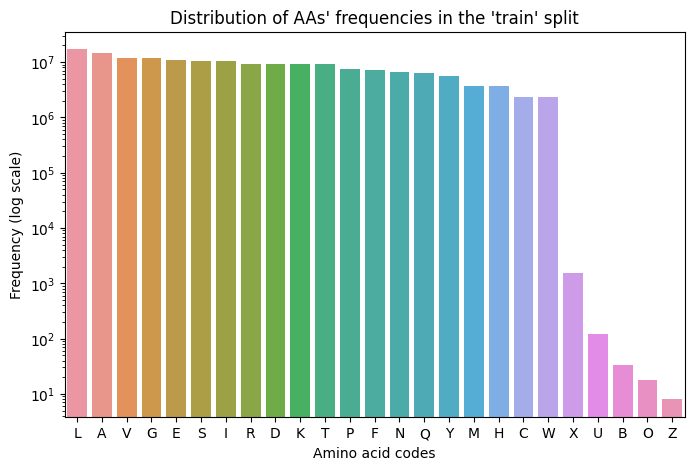

In [16]:
# Plot the distribution of AA frequencies

f, ax = plt.subplots(figsize=(8, 5))

amino_acid_counter = get_amino_acid_frequencies(train_data)

sns.barplot(x='AA', y='Frequency', data=amino_acid_counter.sort_values(by=['Frequency'], ascending=False), ax=ax)

plt.title("Distribution of AAs' frequencies in the 'train' split")
plt.xlabel("Amino acid codes")
plt.ylabel("Frequency (log scale)")
plt.yscale("log")
plt.show()


Eventually, one can observe that some amino acids (`X, U, B, O, Z`) are quite rare compared to other ones. We choose to consider those rare amino acids as unknown (`<unk>`) amino acids but this can be changed.

---

In [17]:
def build_vocab(data):
    # Build the vocabulary
    voc = set()
    rare_AAs = {'X', 'U', 'B', 'O', 'Z'}
    for sequence in data:
        voc.update(sequence)

    unique_AAs = sorted(voc - rare_AAs)
    
    # Build the mapping
    word2id = {w: i for i, w in enumerate(unique_AAs, start=2)}
    word2id['<pad>'] = 0
    word2id['<unk>'] = 1
    
    return word2id

In [18]:
word2id = build_vocab(train_data)

In [57]:
print(word2id, len(word2id))

{'A': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'V': 19, 'W': 20, 'Y': 21, '<pad>': 0, '<unk>': 1} 22


In [70]:
print(word2id.keys())

dict_keys(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '<pad>', '<unk>'])


In [21]:
print(f"AA dictionary formed. The length of dictionary is: {len(word2id)}.")

AA dictionary formed. The length of dictionary is: 22.


In [22]:
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, word2id, fam2label, max_len, data_path, split):
        self.word2id = word2id
        self.fam2label = fam2label
        self.max_len = max_len
        
        self.data, self.label = reader(split, data_path)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        seq = self.preprocess(self.data.iloc[index])
        label = self.fam2label.get(self.label.iloc[index], self.fam2label['<unk>'])
       
        return {'sequence': seq, 'target' : label}
    
    def preprocess(self, text):
        seq = []
        
        # Encode into IDs
        for word in text[:self.max_len]:
            seq.append(self.word2id.get(word, self.word2id['<unk>']))
                
        # Pad to maximal length
        if len(seq) < self.max_len:
            seq += [self.word2id['<pad>'] for _ in range(self.max_len - len(seq))]
                
        # Convert list into tensor
        seq = torch.from_numpy(np.array(seq))
            
        # One-hot encode    
        one_hot_seq = torch.nn.functional.one_hot(seq, num_classes=len(self.word2id), ) 

        # Permute channel (one-hot) dim first
        one_hot_seq = one_hot_seq.permute(1,0)

        return one_hot_seq

In [23]:
seq_max_len = 120

In [24]:
train_dataset = SequenceDataset(word2id, fam2label, seq_max_len, data_dir, "train")
dev_dataset = SequenceDataset(word2id, fam2label, seq_max_len, data_dir, "dev")
test_dataset = SequenceDataset(word2id, fam2label, seq_max_len, data_dir, "test")

In [25]:
# Health check: test the dataset

next(iter(train_dataset))['sequence'].shape

torch.Size([22, 120])

In [26]:
batch_size = 1

In [27]:
num_workers = 0

dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers,
)
dataloaders['dev'] = torch.utils.data.DataLoader(
    dev_dataset,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers,
)
dataloaders['test'] = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=False,
    num_workers=num_workers,
)

In [28]:
# Health check with the dataloader

batch = next(iter(dataloaders['test']))
batch['sequence'].shape, batch['target'].shape

(torch.Size([1, 22, 120]), torch.Size([1]))

## Step 2: Build the classification model

In [29]:
num_classes = len(fam2label)

In [30]:
class Lambda(torch.nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

class ResidualBlock(torch.nn.Module):
    """
    The residual block used by ProtCNN (https://www.biorxiv.org/content/10.1101/626507v3.full).
    
    Args:
        in_channels: The number of channels (feature maps) of the incoming embedding
        out_channels: The number of channels after the first convolution
        dilation: Dilation rate of the first convolution
    """
    
    def __init__(self, in_channels, out_channels, dilation=1):
        super().__init__()   
        
        # Initialize the required layers
        self.skip = torch.nn.Sequential()
            
        self.bn1 = torch.nn.BatchNorm1d(in_channels)
        self.conv1 = torch.nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=3, bias=False, dilation=dilation, padding=dilation)
        self.bn2 = torch.nn.BatchNorm1d(out_channels)
        self.conv2 = torch.nn.Conv1d(in_channels=out_channels, out_channels=out_channels, 
                               kernel_size=3, bias=False, padding=1)
        
    def forward(self, x):
        # Execute the required layers and functions
        activation = F.relu(self.bn1(x))
        x1 = self.conv1(activation)
        x2 = self.conv2(F.relu(self.bn2(x1)))
        
        return x2 + self.skip(x)

In [31]:
class ProtCNN(pl.LightningModule):
    
    def __init__(self, num_classes):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv1d(22, 128, kernel_size=1, padding=0, bias=False),
            ResidualBlock(128, 128, dilation=2),
            ResidualBlock(128, 128, dilation=3),
            torch.nn.MaxPool1d(3, stride=2, padding=1),
            Lambda(lambda x: x.flatten(start_dim=1)),
            torch.nn.Linear(7680, num_classes)
        )
        
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        
    def forward(self, x):
        return self.model(x.float())
    
    def training_step(self, batch, batch_idx):
        x, y = batch['sequence'], batch['target']
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        
        pred = torch.argmax(y_hat, dim=1)
        self.train_acc(pred, y)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch['sequence'], batch['target']
        y_hat = self(x)
        pred = torch.argmax(y_hat, dim=1)        
        acc = self.valid_acc(pred, y)
        self.log('valid_acc', self.valid_acc, on_step=False, on_epoch=True)

        return acc
        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-2)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 8, 10, 12, 14, 16, 18, 20], gamma=0.9)

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
        }


In [32]:
prot_cnn = ProtCNN(num_classes)

In [33]:
pl.seed_everything(0)

Global seed set to 0


0

In [34]:
# Health check: test that the network works on a single mini-batch

batch = next(iter(dataloaders['train']))
print(batch["sequence"].shape)
prot_cnn(batch["sequence"]).shape

torch.Size([1, 22, 120])


[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


torch.Size([1, 17930])

In [35]:
gpus = 0
epochs = 25

In [36]:
trainer = pl.Trainer(gpus=gpus, max_epochs=epochs)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [37]:
trainer.fit(prot_cnn, dataloaders['train'], dataloaders['dev'])


  | Name      | Type       | Params
-----------------------------------------
0 | model     | Sequential | 137 M 
1 | train_acc | Accuracy   | 0     
2 | valid_acc | Accuracy   | 0     
-----------------------------------------
137 M     Trainable params
0         Non-trainable params
137 M     Total params
551.683   Total estimated model params size (MB)


Validation sanity check:  50%|██████████████████████████████████████████████████████████████████████                                                                      | 1/2 [00:00<00:00,  7.59it/s]

/home/mangyinm/others/MLE_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 0
/home/mangyinm/others/MLE_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   1%|▋                                                                                                                         | 7197/1212912 [2:22:00<396:29:29,  1.18s/it, loss=nan, v_num=0]

/home/mangyinm/others/MLE_test/env/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Step 3: Visualize the training

In [29]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [30]:
%tensorboard --logdir "./lightning_logs/"